<a href="https://colab.research.google.com/github/shielamms/Tensorflow-Notebooks/blob/main/Predicting_Sun_Spots_with_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Utility functions

### Plotting function

In [2]:
def plot_series(time,
                series,
                format='-',
                start=0,
                end=None,
                figsize=(10,6),
                title=None,
                xlabel='Time',
                ylabel='Value',
                legend=None):
  
  plt.figure(figsize=figsize)

  # If the arg series is a tuple, there are multiple series to plot
  if isinstance(series, tuple):
    for s in series:
      plt.plot(time[start:end], s[start:end], format)
  else:
    plt.plot(time[start:end], series[start:end], format)

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.grid(True)

  if legend:
    plt.legend(legend)

  plt.show()

### Windowing function

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  # Format the dataset to a tuple of features and labels
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

## Prepare the dataset

In [4]:
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2023-04-18 11:00:00--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2023-04-18 11:00:00 (115 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



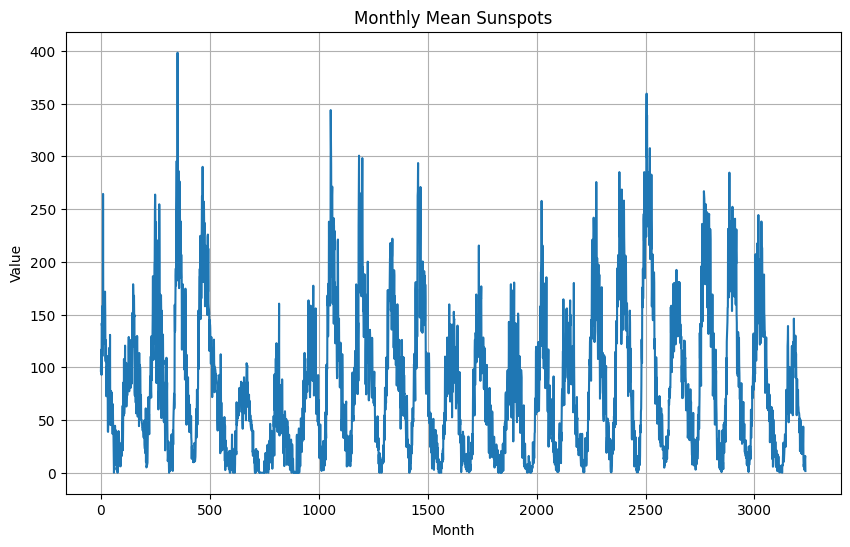

In [8]:
timesteps = []
sunspots = []

with open('Sunspots.csv', 'r') as csv_file:
  reader = csv.reader(csv_file, delimiter=',')

  # skip header
  next(reader)

  for row in reader:
    timesteps.append(int(row[0]))
    sunspots.append(float(row[2]))

  timesteps = np.array(timesteps)
  series = np.array(sunspots)

plot_series(timesteps, series, xlabel='Month', title='Monthly Mean Sunspots')

### Split dataset to training and validation

In [11]:
split_time = 3000

time_train = timesteps[:split_time]
x_train = series[:split_time]

time_valid = timesteps[split_time:]
x_valid = series[split_time:]

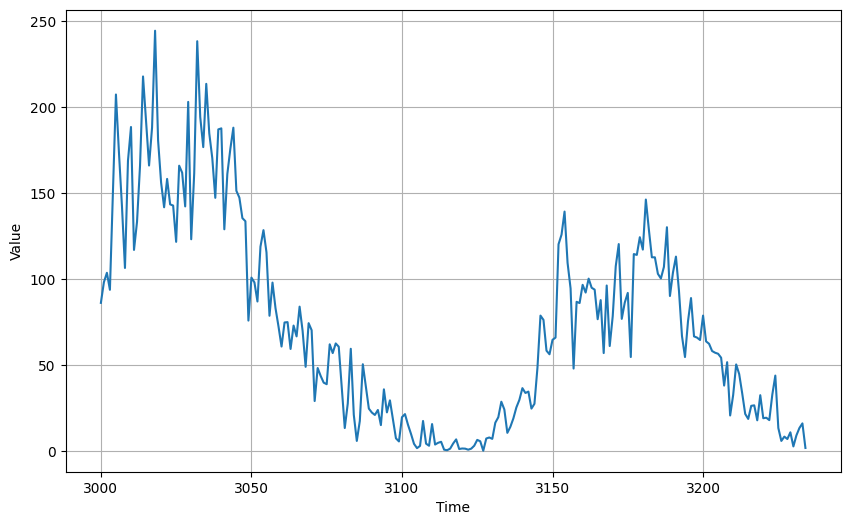

In [12]:
# Plot validation set
plot_series(time_valid, x_valid)

### Prepare features and labels

In [13]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train,
                             window_size,
                             batch_size,
                             shuffle_buffer_size)

# Build the model

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=3,
                           strides=1,
                           padding='causal', 
                           activation='relu',
                           input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Lambda(lambda x: x * 300)
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 68,285
Trainable params: 68,285
Non-traina

### Optimising the SGD optimizer learning rate

In [16]:
init_weights = model.get_weights()

In [17]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

In [18]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 11s 47ms/step - loss: 38.8024 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 6s 58ms/step - loss: 38.3025 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 4s 47ms/step - loss: 37.7460 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 7s 73ms/step - loss: 37.1404 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 10s 100ms/step - loss: 36.5627 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 8s 83ms/step - loss: 36.0281 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 5s 50ms/step - loss: 35.5177 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 10s 103ms/step - loss: 35.0023 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 4s 46ms/step - loss: 34.4672 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 6s 58ms/step - loss: 33.9050 - lr: 2.8184e-08
Epoc

(1e-08, 0.001, 0.0, 100.0)

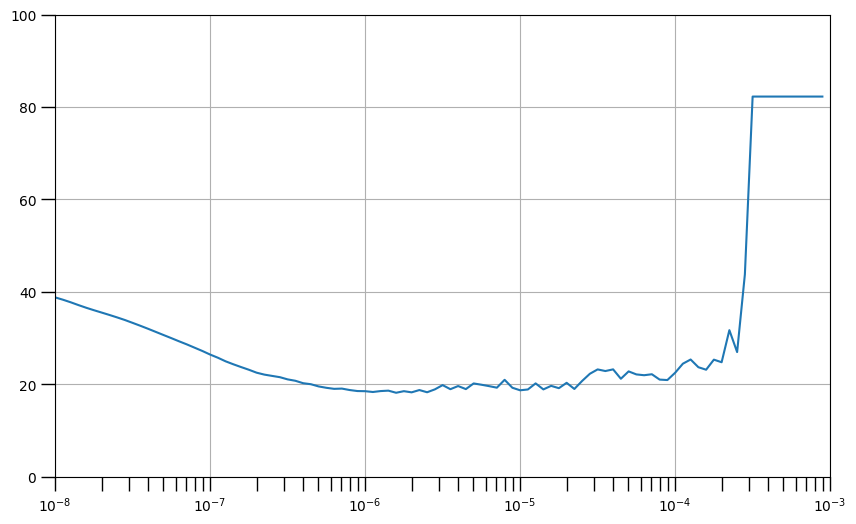

In [19]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 100])

### Train the model

In [20]:
tf.keras.backend.clear_session()

model.set_weights(init_weights)

In [22]:
learning_rate = 8e-7
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,
                                   momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [23]:
history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 [==============================] - 11s 63ms/step - loss: 31.9582 - mae: 32.4481
Epoch 2/100
93/93 [==============================] - 4s 45ms/step - loss: 24.8747 - mae: 25.3630
Epoch 3/100
93/93 [==============================] - 6s 60ms/step - loss: 22.4491 - mae: 22.9382
Epoch 4/100
93/93 [==============================] - 4s 46ms/step - loss: 21.2842 - mae: 21.7730
Epoch 5/100
93/93 [==============================] - 5s 52ms/step - loss: 20.3524 - mae: 20.8401
Epoch 6/100
93/93 [==============================] - 5s 52ms/step - loss: 19.9331 - mae: 20.4195
Epoch 7/100
93/93 [==============================] - 4s 47ms/step - loss: 19.6613 - mae: 20.1485
Epoch 8/100
93/93 [==============================] - 6s 60ms/step - loss: 19.0574 - mae: 19.5460
Epoch 9/100
93/93 [==============================] - 4s 45ms/step - loss: 19.0657 - mae: 19.5526
Epoch 10/100
93/93 [==============================] - 4s 45ms/step - loss: 18.8888 - mae: 19.3760
Epoch 11/100
93/93 [========

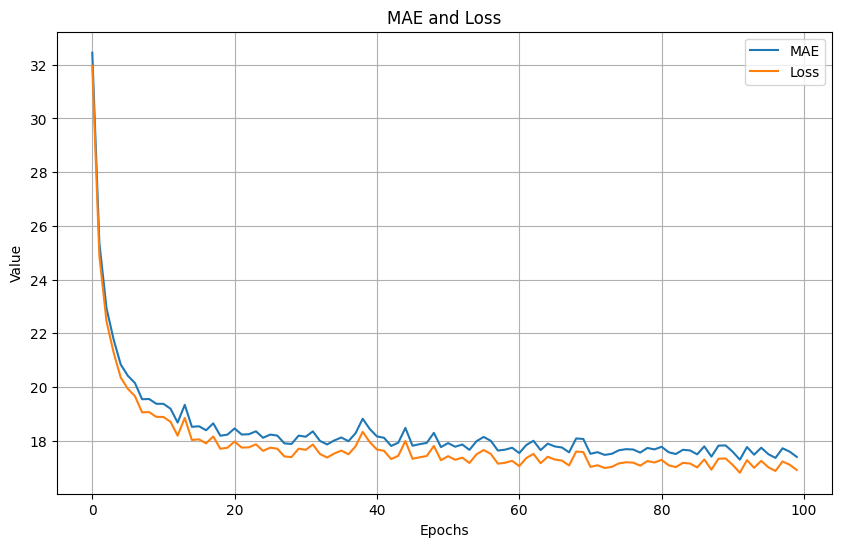

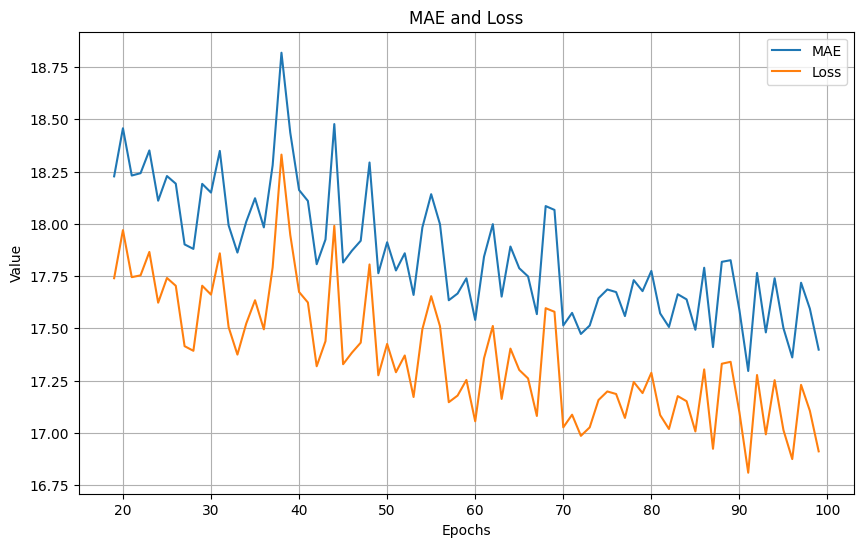

In [25]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    epochs, 
    (mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    epochs_zoom, 
    (mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

## Model prediction

In [26]:
def model_forecast(model, series, window_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(dataset)

  return forecast

8/8 [==============================] - 2s 18ms/step


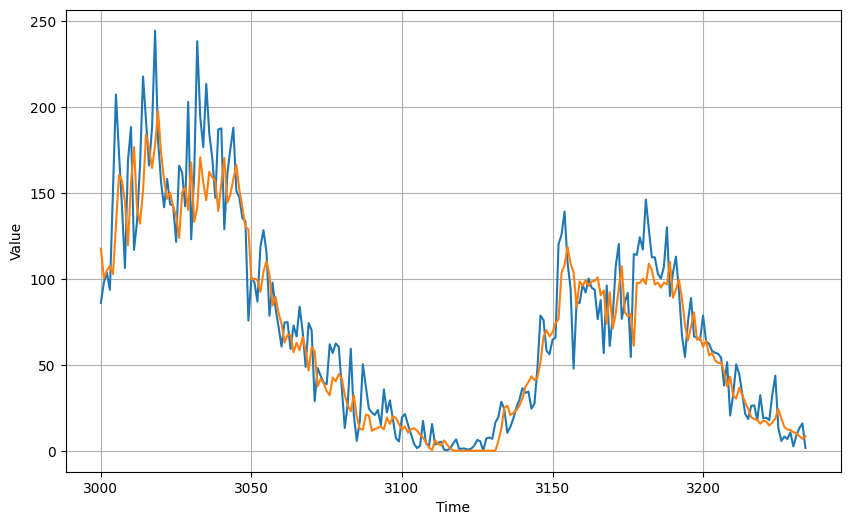

In [27]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [28]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.987942
